<a href="https://colab.research.google.com/github/R3gm/Image-Captioning-Tool/blob/main/notebook_demo_Image_Captioning_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image-Captioning-Tool


| Description | Link |
| ----------- | ---- |
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/Colab-resources/) |


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/facebookresearch/segment-anything.git

--2023-06-18 23:55:55--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.82, 13.35.7.50, 13.35.7.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  96.0MB/s    in 23s     

2023-06-18 23:56:18 (107 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-d0rw957l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-d0rw957l
  Resolved https://github.com/huggingface/transformers.git to commit ee88ae59940fd4b2c8fc119373

In [ ]:
import torch
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from PIL import Image
import requests
import matplotlib.pyplot as plt
import cv2

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

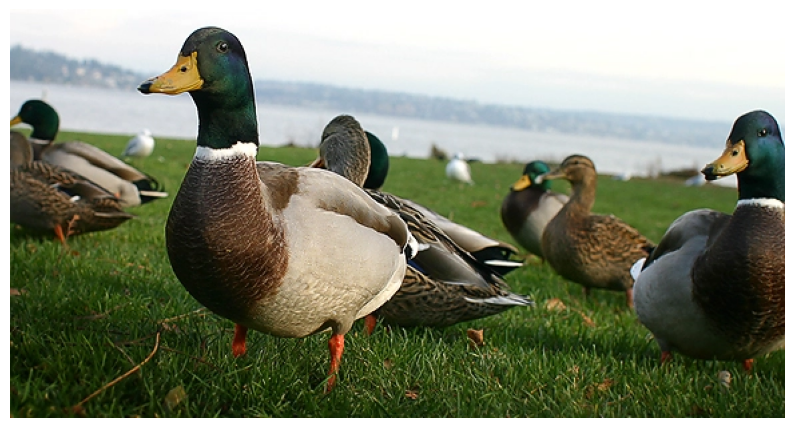

In [ ]:
link = "https://awionline.org/sites/default/files/styles/art/public/page/image/mallard_flickr_tifotter.webp?itok=yZs3snky"

response = requests.get(link, stream=True).raw
image_array = np.asarray(bytearray(response.read()), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

# SAM

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch_dtype = torch.float16 if 'cuda' in device else torch.float32
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'

In [ ]:
# SAM mask
model = sam_model_registry[model_type](checkpoint = checkpoint)
model.to(device)
predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)
predictor.set_image(np.array(image))

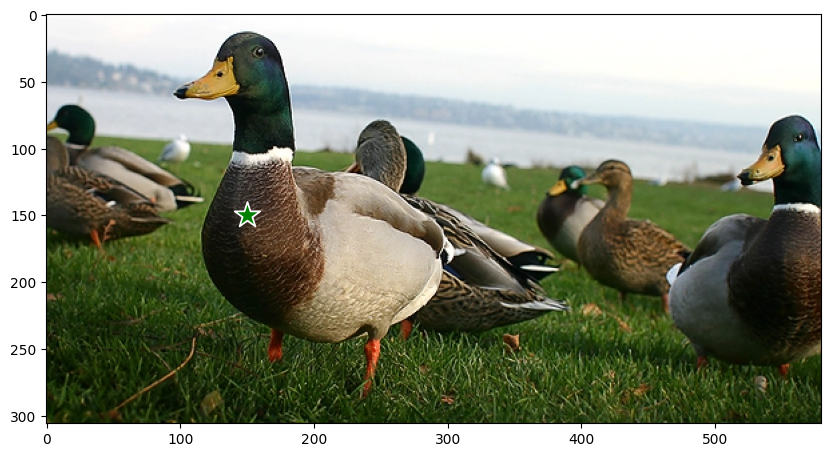

In [ ]:
# Select a point
input_point = np.array([[150, 150]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

## Create and select a mask

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords = input_point,
    point_labels = input_label,
    multimask_output=True,
    )
masks = masks[2, ...]

In [ ]:
masks.shape

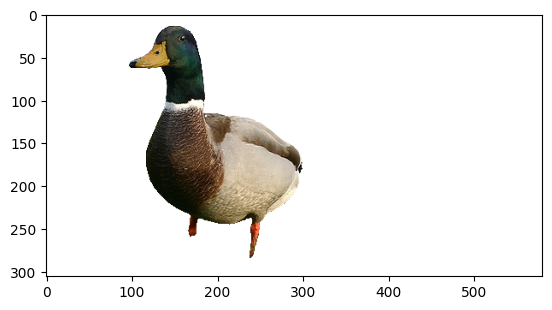

In [ ]:
# Return rgb image
mask = image * masks[:,:,np.newaxis] + (1 - masks[:,:,np.newaxis]) * 255
mask = np.uint8(mask)
plt.imshow(mask)
plt.show()

## Crop the image


In [ ]:
def boxes(array):

  up = botton = 0

  for i in range(array.shape[0]-1):
    if np.all(array[i] == 255):
        up = i
    else:
      print(i-1)
      break

  for i in range(array.shape[0]-1, -1, -1):
    if np.all(array[i] == 255):
        botton = i
    else:
      print(i-1)
      break

  return up, botton

In [ ]:
top, bottom = boxes(mask[:,:,0])
left, right = boxes(mask[:,:,0].T)
cropped_array = mask[top:bottom, left:right]

13
283
96
298


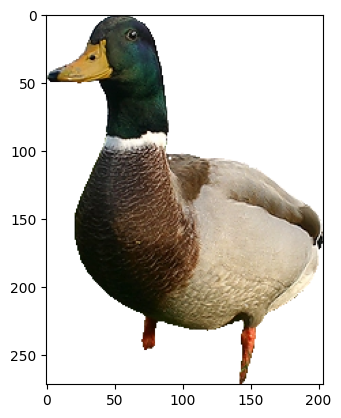

In [ ]:
plt.imshow(cropped_array)
plt.show()

# Caption.


In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from PIL import Image

git_processor_large = AutoProcessor.from_pretrained("microsoft/git-large-vqav2")
git_model_large = AutoModelForCausalLM.from_pretrained("microsoft/git-large-vqav2")
device = "cuda" if torch.cuda.is_available() else "cpu"
git_model_large.to(device)

def generate_answer(processor, model, image, question):
    # prepare image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # prepare question
    input_ids = processor(text=question, add_special_tokens=False).input_ids
    input_ids = [processor.tokenizer.cls_token_id] + input_ids
    input_ids = torch.tensor(input_ids).unsqueeze(0).float().to(device)
    input_ids = input_ids.to(torch.long)

    #print(input_ids.device, pixel_values.device)
    generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
    generated_answer = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_answer

In [ ]:
answer_git_base = generate_answer(
    git_processor_large,
    git_model_large,
    cropped_array,
    'What is?')
answer_git_base[0][9:]

'duck'